In [1]:
import pandas as pd
import matplotlib
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#load dataset, Time(UTC),prs(m),rad(m)
df = pd.read_csv('data2y.csv',sep=',', header=0, index_col=0, squeeze=True, parse_dates=True)
#non-null object to float64
df['prs(m)'] = pd.to_numeric(df['prs(m)'], errors='coerce')
#prs(m) looks more stable
df.drop(df.columns[[1]], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1036988 entries, 2016-12-31 00:00:52 to 2018-12-30 23:59:19
Data columns (total 1 columns):
prs(m)    1036833 non-null float64
dtypes: float64(1)
memory usage: 15.8 MB


In [3]:
df = df.interpolate()

In [4]:
# one week for prediction work
unknown = 60*24*7
r = df[:-unknown]
p = df[-unknown:]

In [5]:
r.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1026908 entries, 2016-12-31 00:00:52 to 2018-12-23 05:52:17
Data columns (total 1 columns):
prs(m)    1026908 non-null float64
dtypes: float64(1)
memory usage: 15.7 MB


In [6]:
p.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10080 entries, 2018-12-23 05:53:17 to 2018-12-30 23:59:19
Data columns (total 1 columns):
prs(m)    10080 non-null float64
dtypes: float64(1)
memory usage: 157.5 KB


In [7]:
serie= r['prs(m)']
serie = serie - np.mean(r.values)
#Sampling interval in hours, default = 1.
dt = 1/60
#The start time of the series, in matplotlib_datenum format (default empty).
stime = r.index[0]
lat = -33.02730833


# TTIDE

In [8]:
import ttide
print(ttide.__version__)

0.3lfk


In [9]:
out = ttide.t_tide(serie, dt, stime, lat)

C:\Users\sergi\Anaconda3\lib\site-packages\ttide-0.3_exp-py3.7.egg\ttide\t_tide.py:345: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef = np.linalg.lstsq(lhs, rhs)[0].T
C:\Users\sergi\Anaconda3\lib\site-packages\numpy\lib\type_check.py:161: FutureWarning: `real` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.real(ser.to_numpy())` or `ser.to_numpy().real`.
  return val.real
C:\Users\sergi\Anaconda3\lib\site-packages\numpy\lib\type_check.py:204: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  return val.imag


-----------------------------------
nobs = 1026908 
ngood = 1026907 
record length (days) = 713.13
start time: 2016-12-31 00:00:52
rayleigh criterion = 1.0

Greenwich phase computed with nodal
                   corrections applied to amplitude
                   and phase relative to center time

x0= 0.000986  xtrend= 0
var(data)= 0.14    var(prediction)= 0.02    var(residual)= 0.13
var(prediction)/var(data) (%) = 15.0

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
* SA    0.0001141     0.0461     0.011    246.15     29.29        16
* SSA   0.0002282     0.0505     0.019    199.34     28.32       7.3
  MSM   0.0013098     0.0035     0.017    344.10    177.57     0.039
  MM    0.0015122     0.0104     0.016    235.42     81.35       0.4
  MSF   0.0028219     0.0018     0.015    306.89    245.79     0.014
  MF    0.0030501     0.0029     0.016    128.50    187.28     0.031
  ALP1  0.0343966     0.0009     0.018

C:\Users\sergi\Anaconda3\lib\site-packages\ttide-0.3_exp-py3.7.egg\ttide\t_utils.py:447: FutureWarning: `real` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.real(ser.to_numpy())` or `ser.to_numpy().real`.
  x = np.var(out['xingd'].real, ddof=1)
C:\Users\sergi\Anaconda3\lib\site-packages\ttide-0.3_exp-py3.7.egg\ttide\t_utils.py:449: FutureWarning: `real` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.real(ser.to_numpy())` or `ser.to_numpy().real`.
  xr = np.var(out['xresgd'].real, ddof=1)


In [10]:
out.keys()

dict_keys(['nobs', 'ngood', 'dt', 'xin', 'xout', 'xres', 'xingd', 'xoutgd', 'xresgd', 'isComplex', 'ray', 'nodcor', 'z0', 'dz0', 'fu', 'nameu', 'tidecon', 'snr', 'synth', 'lat', 'ltype', 'stime'])

In [11]:
out.get("xout")

array([[0.12235993],
       [0.12306434],
       [0.12376243],
       ...,
       [0.30022065],
       [0.29958445],
       [0.29892976]])

## Data to predict

In [12]:
from datetime import datetime
from matplotlib.dates import date2num

#getting te dates
dates = date2num(r.index.to_pydatetime())
#dates = np.array(r.index.to_pydatetime(), dtype=numpy.datetime64)
dates

array([736329.00060185, 736329.00130787, 736329.00199074, ...,
       737051.24325231, 737051.24394676, 737051.2446412 ])

In [13]:
t_tides_p = ttide.t_predic(dates, out.get("nameu"), out.get("fu"), out.get("tidecon"), lat)

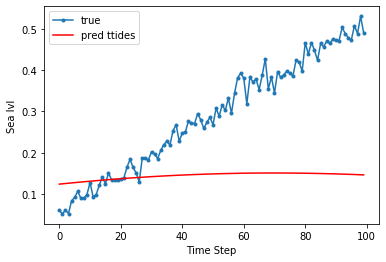

In [14]:
plt.plot(serie.values[:100], marker='.', label="true")
plt.plot(t_tides_p[:100], 'r', label="pred ttides")
plt.ylabel('Sea lvl')
plt.xlabel('Time Step')
plt.legend()
plt.show();

C:\Users\sergi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


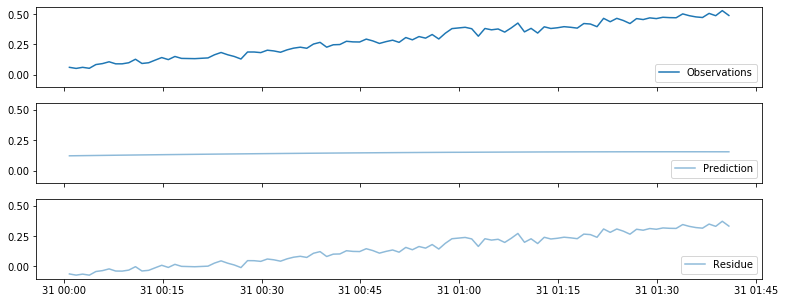

In [15]:
dates = r.index[:100]
obs = out.get("xin")[:100]
xout = out.get("xout")[:100].squeeze()

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(13, 5))

ax0.plot(dates, obs, label=u'Observations')
ax0.legend(numpoints=1, loc='lower right')

ax1.plot(dates, xout, alpha=0.5, label=u'Prediction')
ax1.legend(numpoints=1, loc='lower right')

ax2.plot(dates, obs- xout , alpha=0.5, label=u'Residue')
_ = ax2.legend(numpoints=1, loc='lower right')




# UTIDE  

In [16]:
import utide
import matplotlib.dates as mdates
print(utide.__version__)

0.2.5


In [17]:
time = mdates.date2num(r.index.to_pydatetime())

utcoef = utide.solve(time, serie, lat=lat)
#solve: matrix prep ... solution ... diagnostics ... done.

solve: matrix prep ... solution ... diagnostics ... done.


In [18]:
utcoef.keys()

dict_keys(['name', 'aux', 'nR', 'nNR', 'nI', 'weights', 'A', 'g', 'mean', 'slope', 'g_ci', 'A_ci', 'diagn'])

In [19]:
utcoef

{'name': array(['M2', 'K1', 'S2', 'O1', 'N2', 'SSA', 'P1', 'K2', 'SA', 'MU2', 'Q1',
        'NU2', '2N2', 'L2', 'J1', 'NO1', 'OO1', 'T2', 'MF', 'MM', 'PI1',
        'EPS2', 'H1', 'RHO1', 'ETA2', 'MSF', 'MSM', 'SIG1', 'M3', 'LDA2',
        'GAM2', 'PHI1', 'CHI1', 'SK3', 'THE1', 'MKS2', '2Q1', 'R2', 'M4',
        'MSN2', 'TAU1', 'OQ2', 'BET1', 'SO3', 'PSI1', '2MS6', 'SO1', 'S4',
        'MO3', 'H2', 'S1', 'MK3', '2MK5', 'SK4', 'UPS1', '2MK6', '2SK5',
        '2MN6', 'MSK6', 'MN4', 'M6', 'SN4', '3MK7', 'MS4', 'ALP1', 'M8',
        '2SM6', 'MK4'], dtype=object),
 'aux': {'frq': array([0.0805114 , 0.04178075, 0.08333333, 0.03873065, 0.07899925,
         0.00022816, 0.04155259, 0.08356149, 0.00011407, 0.07768947,
         0.0372185 , 0.07920162, 0.0774871 , 0.08202355, 0.0432929 ,
         0.04026859, 0.04483084, 0.08321926, 0.00305009, 0.00151215,
         0.04143851, 0.07617732, 0.08039733, 0.03742087, 0.08507364,
         0.00282193, 0.00130978, 0.03590872, 0.1207671 , 0.08182118,
       

In [20]:
utcoef.get("name")

array(['M2', 'K1', 'S2', 'O1', 'N2', 'SSA', 'P1', 'K2', 'SA', 'MU2', 'Q1',
       'NU2', '2N2', 'L2', 'J1', 'NO1', 'OO1', 'T2', 'MF', 'MM', 'PI1',
       'EPS2', 'H1', 'RHO1', 'ETA2', 'MSF', 'MSM', 'SIG1', 'M3', 'LDA2',
       'GAM2', 'PHI1', 'CHI1', 'SK3', 'THE1', 'MKS2', '2Q1', 'R2', 'M4',
       'MSN2', 'TAU1', 'OQ2', 'BET1', 'SO3', 'PSI1', '2MS6', 'SO1', 'S4',
       'MO3', 'H2', 'S1', 'MK3', '2MK5', 'SK4', 'UPS1', '2MK6', '2SK5',
       '2MN6', 'MSK6', 'MN4', 'M6', 'SN4', '3MK7', 'MS4', 'ALP1', 'M8',
       '2SM6', 'MK4'], dtype=object)

In [21]:
#dates = mdates.date2num(r.index.to_pydatetime())
ut_rec = utide.reconstruct(time, utcoef)
#prep/calcs ... done.

prep/calcs ... done.


In [22]:
ut_rec.keys()

dict_keys(['t_in', 'epoch', 'constit', 'min_SNR', 'min_PE', 't_mpl', 'h'])

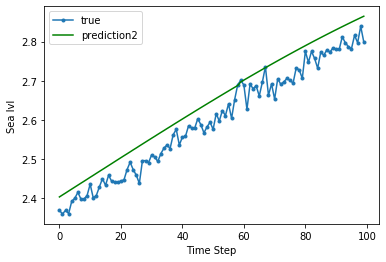

In [23]:
plt.plot(r.values[:100], marker='.', label="true")
#plt.plot(tide["h"]+numpy.mean(p.values), 'r', label="prediction")
plt.plot(ut_rec["h"][:100] + np.mean(r.values), 'g', label="prediction2")
plt.ylabel('Sea lvl')
plt.xlabel('Time Step')
plt.legend()
plt.show();

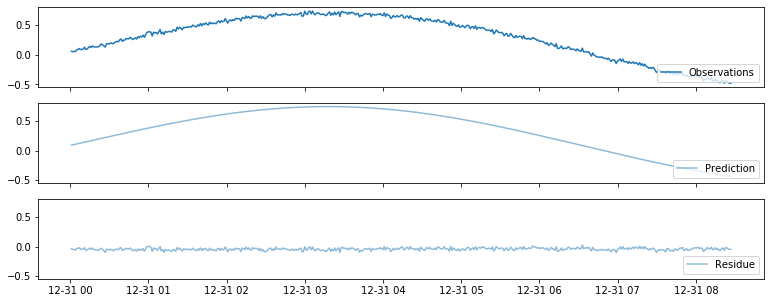

In [28]:
dates = r.index[:500]
obs = serie[:500]
xout = ut_rec.get("h")[:500].squeeze()
res = obs- xout

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(13, 5))

ax0.plot(dates, obs, label=u'Observations')
ax0.legend(numpoints=1, loc='lower right')

ax1.plot(dates, xout, alpha=0.5, label=u'Prediction')
ax1.legend(numpoints=1, loc='lower right')

ax2.plot(dates, res , alpha=0.5, label=u'Residue')
_ = ax2.legend(numpoints=1, loc='lower right')

# LSTM data prep

In [ ]:
res = serie - ut_rec.get("h").squeeze()
resdf = pd.DataFrame(data = res)
resdf.rename(columns={'prs(m)':'residue'},inplace=True)
resdf

In [67]:
#resdf.to_csv('res2y_utide.csv', index = True)